In [1]:
try:
    import davos
except:
    %pip install davos
davos.config.suppress_stdout = True

In [2]:
from bs4 smuggle BeautifulSoup     # pip: beautifulsoup4==4.12.2
smuggle requests                   # pip: requests==2.28.2
from tqdm smuggle tqdm             # pip: tqdm==4.65.0
smuggle textract                   # pip: textract==1.6.4
smuggle Levenshtein                # pip: levenshtein
smuggle fuzzywuzzy                 # pip: fuzzywuzzy==0.18.0
smuggle unidecode                  # pip: Unidecode==1.3.6
smuggle pandas as pd               # pip: pandas==2.0.1
smuggle numpy as np                # pip: numpy==1.25.2
smuggle seaborn as sns             # pip: seaborn==0.12.2
from matplotlib smuggle pyplot as plt  # pip: matplotlib==3.7.1
from IPython.display import Markdown
smuggle openai                     # pip: openai==0.27.9

smuggle re
smuggle os
smuggle urllib
smuggle json
smuggle string
smuggle warnings
smuggle pickle
from glob smuggle glob as lsdir

from pathlib smuggle Path

from helpers smuggle format_filename, get_soup, get_pdf_text, get_doc_text, get_dialogue

In [15]:
prompt_file = Path.cwd().parent.joinpath('data', 'prompt.txt')
api_key_file = Path.cwd().parent.joinpath('data', 'api_key.txt')
model = "gpt-3.5-turbo"
chunk_size = 10

def generate_gpt_responses_by_chunk(data_folder, prompt_file, api_key_file, model="gpt-3.5-turbo",
                                    chunk_size=20, max_files=None):
    # Read API key
    with open(api_key_file, 'r') as f:
        openai.api_key = f.read().strip()
        
    # Read prompt template
    with open(prompt_file, 'r') as f:
        prompt_template = f.read()
    
    # Initialize variables
    all_responses = pd.DataFrame()
    all_errors = []

    # Calculate total number of chunks for tqdm
    total_chunks = 0
    for file in os.listdir(data_folder)[:max_files]:
        if file.endswith('.txt'):
            with open(os.path.join(data_folder, file), 'r') as f:
                text = f.read()
            
            sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
            sentences = [' '.join(s.strip().split()) for s in sentences if len(s.strip()) > 0]
            total_chunks += -(-len(sentences) // chunk_size)

    # Initialize tqdm
    pbar = tqdm(total=total_chunks)
    
    # Start generating responses
    for file in os.listdir(data_folder)[:max_files]:
        if not file.endswith('.txt'):
            continue

        pkl_filename = f"{file[:-4]}_chunk{chunk_size}.pkl"
        pkl_filepath = os.path.join(data_folder, pkl_filename)

        if os.path.exists(pkl_filepath):
            # Load existing data
            with open(pkl_filepath, 'rb') as f:
                responses_df, file_errors = pickle.load(f)
        else:
            # Read and chunk file
            with open(os.path.join(data_folder, file), 'r') as f:
                text = f.read()
            
            sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
            sentences = [' '.join(s.strip().split()) for s in sentences if len(s.strip()) > 0]
            
            chunks = [sentences[i:i + chunk_size] for i in range(0, len(sentences), chunk_size)]
            responses_df = pd.DataFrame(columns=['file', 'chunk_idx', 'response'])
            file_errors = []
            
            # Generate GPT responses for each chunk
            for i, chunk in enumerate(chunks):
                prompt = prompt_template.replace("{text}", ' '.join(chunk))

                response = openai.ChatCompletion.create(model=model, messages=[{"role": "system", "content": "You are a helpful assistant and an expert linguist. You are extremely good at following instructions."},
                                                                               {"role": "user", "content": prompt}])['choices'][0]['message']['content']
                    
                responses_df = responses_df._append(pd.DataFrame({'file': [file], 'chunk_idx': [i], 'response': [response]}), ignore_index=True)
                pbar.update(1)

            # Save chunk responses to a pickle file
            with open(pkl_filepath, 'wb') as f:
                pickle.dump((responses_df, file_errors), f)
        
        # Append responses and errors
        all_responses = all_responses._append(responses_df, ignore_index=True)
        all_errors.extend([(file, *error_tuple) for error_tuple in file_errors])
        
    pbar.close()
    return all_responses, all_errors

In [16]:
def parse_and_summarize_gpt_responses(all_responses):
    results_df = pd.DataFrame(columns=["filename", "past_count", "future_count"])

    for responses_df in all_responses:
        filename = responses_df.iloc[0]['filename']
        total_past = 0
        total_future = 0
        for index, row in responses_df.iterrows():
            output = row['response']
            try:
                parts = output.split('F')
                past_count = int(parts[0][1:])
                future_count = int(parts[1])
                total_past += past_count
                total_future += future_count
            except ValueError:
                pass  # Ignore incorrectly formatted responses
        
        new_row = {"filename": filename, "past_count": total_past, "future_count": total_future}
        results_df = results_df._append(new_row, ignore_index=True)

    return results_df

Compare manually vs. automatically tagged references from *The Chair*

In [153]:
# fill in proportions for manual reference counts
ref_fname = str(Path.cwd().parent.joinpath('data', 'the_chair', 'the_chair_manual_reference_counts.csv'))
manual = pd.read_csv(ref_fname)
manual['Total'] = manual['Past'] + manual['Future']

# # compute proportions
# manual['p(Past)'] = manual['Past'] / manual['Total']
# manual['p(Future)'] = manual['Future'] / manual['Total']

manual.reset_index(inplace=True)
manual['Episode'] = manual['index'] + 1
manual.drop(['index', 'Total'], axis=1, inplace=True)

manual = manual.melt(var_name='tense', value_name='count', id_vars=['Episode'])
manual.sort_values(['Episode'], inplace=True)
manual.reset_index(inplace=True, drop=True)
manual['proportion'] = manual['count'] / manual.groupby('Episode')['count'].transform('sum')
manual

,Episode,tense,count,proportion
0,1,Past,60,0.769231
1,1,Future,18,0.230769
2,2,Past,30,0.681818
3,2,Future,14,0.318182
4,3,Past,43,0.565789
5,3,Future,33,0.434211
6,4,Past,31,0.596154
7,4,Future,21,0.403846
8,5,Past,36,0.765957
9,5,Future,11,0.234043


In [155]:
chair_dir = Path.cwd().parent.joinpath('data', 'the_chair')

chair_results_fname = chair_dir.joinpath(f'the_chair_gpt_responses_c{chunk_size}.pkl')

if chair_results_fname.exists():
    with open(chair_results_fname, 'rb') as f:
        auto, errors = pickle.load(f)
else:
    auto, errors = generate_gpt_responses_by_chunk(chair_dir, prompt_file=prompt_file, api_key_file=api_key_file, chunk_size=chunk_size, max_files=10, model=model)
    with open(chair_results_fname, 'wb') as f:
        pickle.dump((auto, errors), f)

In [156]:
def fix_json_string(bad_json_str):
    result = []
    is_key = True  # Tracks if we are within a key
    is_value = False  # Tracks if we are within a value
    is_escaped = False  # Tracks if the current character is escaped (preceded by a backslash)
    quote_type = None  # Tracks the type of quote (' or ") for the current key or value

    for c in bad_json_str:
        if c == '\\':  # Escape character
            is_escaped = not is_escaped
            result.append(c)
        elif (c == '"' or c == "'") and not is_escaped:  # Quote character
            if quote_type is None:  # Starting a new quoted section
                quote_type = c
                result.append('"')  # Always use double quotes in the output
            elif quote_type == c:  # Ending the current quoted section
                quote_type = None
                result.append('"')  # Always use double quotes in the output
                is_key = not is_key  # Toggle is_key because keys and values alternate
                is_value = not is_value  # Toggle is_value as well
            else:
                result.append(c)  # Leave other quotes untouched
        elif c == ':' and quote_type is None:  # Colon (only meaningful outside of quotes)
            is_key = False
            is_value = True
            result.append(c)
        elif c == ',' and quote_type is None:  # Comma (only meaningful outside of quotes)
            is_key = True
            is_value = False
            result.append(c)
        else:  # All other characters
            result.append(c)

        # Reset the escape flag if the current character was not a backslash
        if c != '\\':
            is_escaped = False

    # Join the list into a single string and attempt to parse it as JSON
    fixed_json_str = ''.join(result)
    try:
        fixed_json = json.loads(fixed_json_str)
        return fixed_json
    except json.JSONDecodeError as e:
        print("Failed to decode JSON:", e)
        return None

In [157]:
errors = []
parsed_responses = []

for i, row in auto.iterrows():
    parsed_response = None

    try:
        html = row['response']
        parsed = BeautifulSoup(html).get_text()
        parsed_response = fix_json_string(parsed)
    except:
        pass
    
    if parsed_response is None:
        errors.append({'file': row['file'], 'chunk_idx': row['chunk_idx'], 'response': row['response'], 'iloc': i})
        parsed_responses.append(None)
    else:
        parsed_responses.append(parsed_response)

drop_indices = [e['iloc'] for e in errors]
auto.drop(drop_indices, inplace=True)
auto.reset_index(inplace=True, drop=True)

auto['response'] = [p for p in parsed_responses if p is not None]

past = lambda response: np.sum([int(x['P']) for x in response.values()])
future = lambda response: np.sum([int(x['F']) for x in response.values()])
episode = lambda filename: int(filename.split('_')[2][3])

auto['Past'] = auto['response'].apply(past)
auto['Future'] = auto['response'].apply(future)
auto['Episode'] = auto['file'].apply(episode)

auto = auto.groupby('Episode').agg({'Past': 'sum', 'Future': 'sum'}).reset_index()
auto = auto.melt(var_name='tense', value_name='count', id_vars=['Episode'])
auto.sort_values(['Episode'], inplace=True)
auto.reset_index(inplace=True, drop=True)
auto['proportion'] = auto['count'] / auto.groupby('Episode')['count'].transform('sum')
auto

Failed to decode JSON: Unterminated string starting at: line 1 column 364 (char 363)
Failed to decode JSON: Extra data: line 16 column 1 (char 1188)


,Episode,tense,count,proportion
0,1,Past,80,0.740741
1,1,Future,28,0.259259
2,2,Past,79,0.711712
3,2,Future,32,0.288288
4,3,Past,113,0.748344
5,3,Future,38,0.251656
6,4,Past,87,0.783784
7,4,Future,24,0.216216
8,5,Past,107,0.804511
9,5,Future,26,0.195489


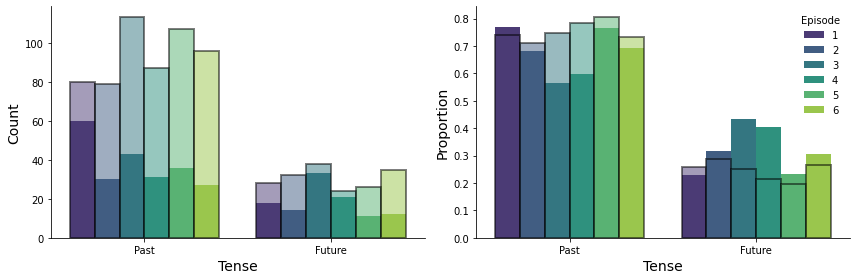

In [164]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=2, sharex=True)

# show counts
sns.barplot(data=manual, x='tense', y='count', hue='Episode', palette='viridis', ax=axes[0])
sns.barplot(data=auto, x='tense', y='count', hue='Episode', palette='viridis', alpha=0.5, edgecolor='k', linewidth=2, ax=axes[0])
axes[0].get_legend().remove()

axes[0].set_xlabel('Tense', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
sns.despine(top=True, right=True)

# show proportions
sns.barplot(data=manual, x='tense', y='proportion', hue='Episode', palette='viridis', ax=axes[1])
sns.barplot(data=auto, x='tense', y='proportion', hue='Episode', palette='viridis', alpha=0.5, edgecolor='k', linewidth=2, ax=axes[1])
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(loc='upper right', title='Episode', handles=handles[:6], labels=labels[:6], frameon=False)

axes[1].set_xlabel('Tense', fontsize=14)
axes[1].set_ylabel('Proportion', fontsize=14)
sns.despine(top=True, right=True)

plt.tight_layout()
fig.savefig('the_chair_events.pdf', bbox_inches='tight')

In [116]:
labels

['1', '2', '3', '4', '5', '6', '1', '2', '3', '4', '5', '6']

# Infer tense from text using NLTK's taggers

Single sentence tagging

In [ ]:
data_dir = str(Path.cwd().parent.joinpath('data'))
tagger = os.path.join(data_dir, 'english-bidirectional-distsim.tagger')
jar = os.path.join(data_dir, 'stanford-postagger.jar')

stanford_tagger = StanfordPOSTagger(tagger, jar, encoding='utf8')

def sentence_tense(x):
  # source: https://stackoverflow.com/questions/30016904/determining-tense-of-a-sentence-python
  def tense_detect(tagged_sentence):        
    verb_tags = ['MD','MDF',
                'BE','BEG','BEN','BED','BEDZ','BEZ','BEM','BER',
                'DO','DOD','DOZ',
                'HV','HVG','HVN','HVD','HVZ',
                'VB','VBG','VBN','VBD','VBZ',
                'SH',
                'TO',                
                'JJ']
    
    verb_phrase = []
    for item in tagged_sentence:
        if item[1] in verb_tags:
            verb_phrase.append(item)

    grammar = r'''
            future perfect continuous passive:     {<MDF><HV><BEN><BEG><VBN|VBD>+}
            conditional perfect continuous passive:{<MD><HV><BEN><BEG><VBN|VBD>+}
            future continuous passive:             {<MDF><BE><BEG><VBN|VBD>+}   
            conditional continuous passive:        {<MD><BE><BEG><VBN|VBD>+}    
            future perfect continuous:             {<MDF><HV><BEN><VBG|HVG|BEG>+}   
            conditional perfect continuous:        {<MD><HV><BEN><VBG|HVG|BEG>+}
            past perfect continuous passive:       {<HVD><BEN><BEG><VBN|VBD>+}
            present perfect continuous passive:    {<HV|HVZ><BEN><BEG><VBN|VBD>+}
            future perfect passive:                {<MDF><HV><BEN><VBN|VBD>+}   
            conditional perfect passive:           {<MD><HV><BEN><VBN|VBD>+}    
            future continuous:                     {<MDF><BE><VBG|HVG|BEG>+ }   
            conditional continuous:                {<MD><BE><VBG|HVG|BEG>+  }   
            future indefinite passive:             {<MDF><BE><VBN|VBD>+ }
            conditional indefinite passive:        {<MD><BE><VBN|VBD>+  }
            future perfect:                        {<MDF><HV><HVN|BEN|VBN|VBD>+ }   
            conditional perfect:                   {<MD><HV><HVN|BEN|VBN|VBD>+  }   
            past continuous passive:               {<BED|BEDZ><BEG><VBN|VBD>+}  
            past perfect continuous:               {<HVD><BEN><HVG|BEG|VBG>+}   
            past perfect passive:                  {<HVD><BEN><VBN|VBD>+}
            present continuous passive:            {<BEM|BER|BEZ><BEG><VBN|VBD>+}   
            present perfect continuous:            {<HV|HVZ><BEN><VBG|BEG|HVG>+}    
            present perfect passive:               {<HV|HVZ><BEN><VBN|VBD>+}
            future indefinite:                     {<MDF><BE|DO|VB|HV>+ }       
            conditional indefinite:                {<MD><BE|DO|VB|HV>+  }   
            past continuous:                       {<BED|BEDZ><VBG|HVG|BEG>+}           
            past perfect:                          {<HVD><BEN|VBN|HVD|HVN>+}
            past indefinite passive:               {<BED|BEDZ><VBN|VBD>+}   
            present indefinite passive:            {<BEM|BER|BEZ><VBN|VBD>+}            
            present continuous:                    {<BEM|BER|BEZ><BEG|VBG|HVG>+}            
            present perfect:                       {<HV|HVZ><BEN|HVD|VBN|VBD>+  }       
            past indefinite:                       {<DOD><VB|HV|DO>|<BEDZ|BED|HVD|VBN|VBD>+}        
            infinitive:                            {<TO><BE|HV|VB>+}
            present indefinite:                    {<DO|DOZ><DO|HV|VB>+|<DO|HV|VB|BEZ|DOZ|BER|HVZ|BEM|VBZ>+}    
            '''

    if len(verb_phrase) > 0:
      cp = nltk.RegexpParser(grammar)
      result = cp.parse(verb_phrase)
    else:
      result = []
    
    tenses_set = set()
    for node in result:
      if type(node) is nltk.tree.Tree:
        tenses_set.add(node.label())
    
    return tenses_set
    
  text = word_tokenize(x)
  tagged = stanford_tagger.tag(x)
  return tense_detect(tagged)

Document-level tagging

In [ ]:
def tag_document(x):
  counts = {}
  for s in tokenize.sent_tokenize(x):
    if len(s) > 0:
      for t in sentence_tense(s):
        counts[t] = counts.get(t, 0) + 1
    else:
      pass
  return counts

# Download datasets

## [Internet Movie Script Database (IMSDb)](https://imsdb.com/)

In [ ]:
imsdb_dir = str(Path.cwd().parent.joinpath('data').joinpath('imsdb'))
if not os.path.exists(imsdb_dir):
  os.makedirs(imsdb_dir)

In [ ]:
def get_imsdb():
    ALL_URL = "https://imsdb.com/all-scripts.html"
    BASE_URL = "https://imsdb.com"
    SOURCE = "imsdb"

    def get_script_from_url(script_url):
        text = ""

        try:
            if script_url.endswith('.pdf'):
                text = get_pdf_text(script_url, os.path.join(SOURCE, file_name))
                return text

            if script_url.endswith('.html'):
                script_soup = get_soup(
                    script_url)
                if script_soup == None:
                    return text
                if len(script_soup.find_all('td', class_="scrtext")) < 1:
                    return ""
                script_text = script_soup.find_all(
                    'td', class_="scrtext")[0].pre

                if script_text:
                    script_text = script_soup.find_all(
                        'td', class_="scrtext")[0].pre.pre
                    if script_text:
                        text = script_text.get_text()

                    else:
                        script_text = script_soup.find_all(
                            'td', class_="scrtext")[0].pre
                        text = script_text.get_text()
        except Exception as err:
            # print(script_url)
            # print(err)
            text = ""

        return text

    def get_script_url(movie):
        script_page_url = movie.contents[0].get('href')
        name = movie.contents[0].text
        movie_name = script_page_url.split("/")[-1].strip('Script.html')

        script_page_soup = get_soup(BASE_URL + urllib.parse.quote(script_page_url))
        if script_page_soup == None:
            return "", name
        paras = script_page_soup.find_all('p', align="center")
        if len(paras) < 1:
            return "", ""
        script_url = paras[0].contents[0].get('href')

        return script_url, name

    soup = get_soup(ALL_URL)
    movielist = soup.find_all('p')

    for movie in tqdm(movielist, desc=SOURCE):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            script_url, name = get_script_url(movie)
    
        if script_url == "":
            continue
        
        script_url = BASE_URL + urllib.parse.quote(script_url)
        file_name = format_filename(name)

        if os.path.exists(os.path.join(imsdb_dir, file_name + '.txt')):
            continue
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            text = get_script_from_url(script_url)

        if text == "" or name == "":
            continue
        
        with open(os.path.join(imsdb_dir, file_name + '.txt'), 'w', errors="ignore") as out:
            out.write(text)

In [ ]:
if os.path.exists(imsdb_dir):
    fnames = [f for f in os.listdir(imsdb_dir) if f.endswith('.txt')]
else:
    fnames = []

if len(fnames) < 1000:
    get_imsdb()
    fnames = [f for f in os.listdir(imsdb_dir) if f.endswith('.txt')]

print(f'Found {len(fnames)} IMSDB scripts.')

Found 1127 IMSDB scripts.


In [ ]:
def count_tokens_in_directory(directory_path):
    filenames = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.txt')]
    total_tokens = 0
    
    for filename in filenames:
        with open(filename, 'r', encoding='utf-8') as file:
            text = file.read()
            tokens = len(text.split())  # A rough approximation
            total_tokens += tokens
    
    return total_tokens

# You need to set the cost per token for each model according to your specific OpenAI plan
cost_per_token_gpt3_5 = 0.000004
cost_per_token_gpt4 = 0.00012

total_tokens = count_tokens_in_directory(imsdb_dir)

total_cost_gpt3_5 = total_tokens * cost_per_token_gpt3_5
total_cost_gpt4 = total_tokens * cost_per_token_gpt4

print(f"Total tokens in the directory: {total_tokens}")
print(f"Estimated cost with GPT-3.5-turbo: ${total_cost_gpt3_5}")
print(f"Estimated cost with GPT-4: ${total_cost_gpt4}")

Total tokens in the directory: 26023895
Estimated cost with GPT-3.5-turbo: $104.09558
Estimated cost with GPT-4: $3122.8674


In [ ]:
smuggle stanza

In [ ]:
stanza.__version__

'1.5.0'

Display a randomly chosen excerpt from a randomly chosen transcript

In [ ]:
sample = np.random.choice(fnames)

with open(os.path.join(imsdb_dir, sample), 'r') as f:
    lines = f.readlines()
    lines = [x.strip() for x in lines if len(x.strip()) > 0]

    # choose a 10 line snippet at random
    start = np.random.randint(0, len(lines) - 10)
    snippet = lines[start:start+10]

Markdown(f'**Excerpt from {sample}:**\n\n' + '\n\n'.join(snippet))

**Excerpt from Lock-Stock-and-Two-Smoking-Barrels.txt:**

Harry, that boy doesn't know his arsehole from his ear-hole, or you

from a hoodwink. This bar is mine, and he has nothing to do with it.

HATCHET

What, and I care? Remember, you do have the luxurious advantage of

being able to sustain your son's life.

JD

And you do have a reputation, so I'll choose my words carefully. But

not to put too fine a point on it, fuck yourself, Harry!

Barry pulls a kind of mock-scared face and clutches his heart.

80

In [ ]:
# chatGPT's solution (after some tweaking)!

def count_tenses_in_files(filepaths):
    df = pd.DataFrame(columns=['filename', 'past_tense', 'future_tense'])

    for filepath in filepaths:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()

        sentences = sent_tokenize(text)

        past_count = 0
        future_count = 0

        for sentence in sentences:
            # Expand contractions for better matching
            sentence = re.sub(r"won't", "will not", sentence)
            sentence = re.sub(r"can't", "cannot", sentence)
            sentence = re.sub(r"i'm", "i am", sentence)
            sentence = re.sub(r"ain't", "is not", sentence)
            sentence = re.sub(r"(\w+)'ll", "\\1 will", sentence)
            sentence = re.sub(r"(\w+)n't", "\\1 not", sentence)
            sentence = re.sub(r"(\w+)'ve", "\\1 have", sentence)
            sentence = re.sub(r"(\w+)'s", "\\1 is", sentence)
            sentence = re.sub(r"(\w+)'re", "\\1 are", sentence)

            # Check for future tense patterns
            if re.search(r'\bwill\b|\bshall\b|\bam going to\b|\bwill have\b|\bshall have\b|\bwill be\b|\bshall be\b|\b(is|are) going to\b|\b(is|are|am) about to\b|\b(is|are|am) planning to\b|\b(is|are|am) looking forward to\b', sentence, re.IGNORECASE):
                future_count += 1

            # Check for past tense patterns
            if re.search(r'\bwas\b|\bwere\b|\bhad\b|\bdid\b|\bhad been\b|\bwas going to\b|\bwere going to\b|\bwas supposed to\b|\bwere supposed to\b|\bwould have\b|\bshould have\b|\bcould have\b|\bmight have\b|\bwas planning to\b|\bwere planning to\b|\bwas looking forward to\b|\bwere looking forward to\b', sentence, re.IGNORECASE):
                past_count += 1

        df = df.append({'filename': filepath, 'past_tense': past_count, 'future_tense': future_count}, ignore_index=True)

    return df

In [ ]:
def add_dict(d1, d2):
  for k in d2:
    if k in d1:
      d1[k] += d2[k]
    else:
      d1[k] = d2[k]
  return d1

Test run: validate against The Chair (Season 1, Episodes 1--6)

In [ ]:
demo_fname = lambda n: str(Path.cwd().parent.joinpath('data').joinpath('the_chair_s1e' + str(n) + '_transcript.txt'))
ref_fname = str(Path.cwd().parent.joinpath('data').joinpath('the_chair_manual_reference_counts.csv'))

def get_demo_tenses(fname):
    text = open(fname, 'r').read()
    tenses = pd.DataFrame.from_dict(tag_document(text), orient='index', columns=['count']).reset_index().rename(columns={'index': 'tense'})

    mapping = {'present indefinite': 'Present',
            'past indefinite': 'Past',
            'conditional indefinite': 'Future',
            'infinitive': 'Present'}

    tenses['index'] = tenses['tense'].apply(lambda x: mapping[x] if x in mapping else x)
    
    # drop present tense
    tenses = tenses.groupby('index').sum().reset_index().sort_values('count', ascending=False).set_index('index').loc[['Past', 'Future']]
    tenses['proportion'] = tenses['count'] / tenses['count'].sum()

    return tenses.drop('tense', axis=1).reset_index().rename(columns={'index': 'tense'})

In [ ]:
# fill in proportions for manual reference counts
manual = pd.read_csv(ref_fname)
manual['Total'] = manual['Past'] + manual['Future']

# convert to proportions
manual['Past'] = manual['Past'] / manual['Total']
manual['Future'] = manual['Future'] / manual['Total']

manual.reset_index(inplace=True)
manual['Episode'] = manual['index'] + 1
manual.drop(['index', 'Total'], axis=1, inplace=True)

manual = manual.melt(var_name='tense', value_name='proportion', id_vars=['Episode'])
manual.sort_values(['Episode'], inplace=True)
manual


,Episode,tense,proportion
0,1,Past,0.769231
6,1,Future,0.230769
1,2,Past,0.681818
7,2,Future,0.318182
2,3,Past,0.565789
8,3,Future,0.434211
3,4,Past,0.596154
9,4,Future,0.403846
4,5,Past,0.765957
10,5,Future,0.234043


In [ ]:
episodes = np.arange(1, 7, dtype=int)
tenses = [get_demo_tenses(demo_fname(n)) for n in episodes]

# add episode labels
for i, t in enumerate(tenses):
    t['episode'] = episodes[i]

# combine into one dataframe
tenses = pd.concat(tenses, ignore_index=True)

sns.barplot(tenses, x='tense', y='proportion', hue='episode', palette='viridis')
plt.xlabel('Tense', fontsize=14)
plt.ylabel('Proportion of references', fontsize=14)
plt.legend(title='Episode', loc='upper right')
sns.despine(top=True, right=True)

ax = plt.gca()

# add manual reference counts as dotted lines
for i, p in enumerate(ax.patches):
    x = [p.get_x(), p.get_x() + p.get_width()]  # X-coordinate of the center of the bar
    y = manual.iloc[i]['proportion']
    ax.plot(x, [y, y], linestyle='dotted', linewidth=2, color='black')

OSError: Java command failed : ['/Users/jmanning/opt/anaconda3/envs/prediction-retrodiction/bin/java', '-mx1000m', '-cp', '/Users/jmanning/prediction-retrodiction-paper/data/stanford-postagger.jar', 'edu.stanford.nlp.tagger.maxent.MaxentTagger', '-model', '/Users/jmanning/prediction-retrodiction-paper/data/english-bidirectional-distsim.tagger', '-textFile', '/var/folders/tp/qtzc39jx5w556wl5w3dj21wr0000gn/T/tmppp4qbrsh', '-tokenize', 'false', '-outputFormatOptions', 'keepEmptySentences', '-encoding', 'utf8']

In [ ]:
os.system('which java')

/Users/jmanning/opt/anaconda3/envs/prediction-retrodiction/bin/java


0

In [ ]:
stanford_tagger.tag('This is a test'.split())

OSError: Java command failed : ['/Users/jmanning/opt/anaconda3/envs/prediction-retrodiction/bin/java', '-mx1000m', '-cp', '/Users/jmanning/prediction-retrodiction-paper/data/stanford-postagger.jar', 'edu.stanford.nlp.tagger.maxent.MaxentTagger', '-model', '/Users/jmanning/prediction-retrodiction-paper/data/english-bidirectional-distsim.tagger', '-textFile', '/var/folders/tp/qtzc39jx5w556wl5w3dj21wr0000gn/T/tmpnv4bm30d', '-tokenize', 'false', '-outputFormatOptions', 'keepEmptySentences', '-encoding', 'utf8']

In [ ]:
all_tenses = []
for f in tqdm(fnames):
  tenses = {}
  dialogue = get_dialogue(os.path.join(imsdb_dir, f))

  if dialogue is None:
    continue

  for d in dialogue['Character_dialogue'].values:
    d = d.strip()
    if len(d) > 0:
      tenses = add_dict(tenses, tag_document(d))
  
  all_tenses.append((f[:-4], tenses))

100%|██████████| 1127/1127 [5:02:25<00:00, 16.10s/it]   


In [ ]:
def tenses2df(all_tenses):
    keys = set()
    for t in all_tenses:
        keys = keys.union(set(t[1].keys()))

    df = pd.DataFrame(columns=list(keys), index=pd.Index([t[0] for t in all_tenses], name='Film'))
    for m, t in all_tenses:
        for k in t:
            df.loc[m, k] = t[k]

    df = df.fillna(0)
    df['Total'] = df.sum(axis=1)

    for k in keys:
        df[k] = df[k] / df['Total']
    df.drop('Total', axis=1, inplace=True)
    return df.dropna(how='all', axis=0)

In [ ]:
df = tenses2df(all_tenses)
df

,conditional indefinite,present indefinite,past indefinite,infinitive
Film,,,,
Midnight-Express,0.061722,0.542012,0.272303,0.123963
Big-Eyes,0.076048,0.555096,0.284532,0.084325
Warrior,0.069118,0.520588,0.272794,0.137500
Hellraiser-Hellseeker,0.088144,0.512725,0.278088,0.121043
Hannah-and-Her-Sisters,0.087430,0.511512,0.270068,0.130989
...,...,...,...,...
Smashed,0.125676,0.448649,0.283108,0.142568
Wild-Wild-West,0.093483,0.529380,0.240385,0.136752
Sessions-The,0.115983,0.505658,0.239745,0.138614


<Axes: xlabel='Proportion', ylabel='Tense'>

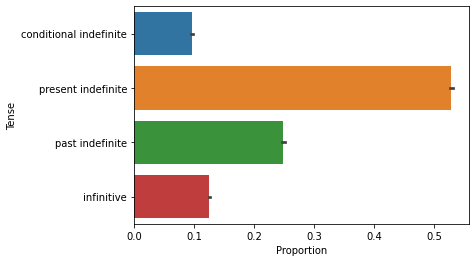

In [ ]:
sns.barplot(data=df.reset_index().melt(id_vars='Film', var_name='Tense', value_name='Proportion'), y='Tense', x='Proportion', orient='h')